## Project Goal

The objective of this customer segmentation project is to identify distinct groups of customers based on their demographic, behavioral, and purchasing patterns. Using clustering techniques, the project aims to:

1. Classify customers into meaningful segments to understand their unique characteristics.
2. Provide actionable insights for personalized marketing strategies tailored to each segment.
3. Enable targeted campaigns that optimize engagement, satisfaction, and revenue growth.

## Libraries

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Mount Google Drive
drive.mount('/content/drive')

#Define the file path
file_path = '/content/drive/My Drive/marketing_campaign.csv'

#Load the dataset
df = pd.read_csv(file_path, delimiter='\t')
print(df.head())

Mounted at /content/drive
     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  C

## K Means Clustering

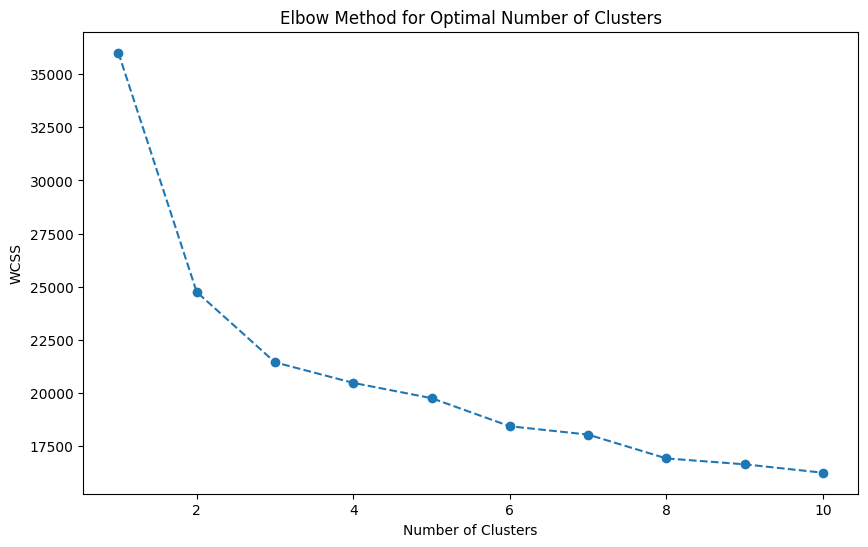

In [ ]:
# Remove rows with missing values in the Income column
df = df.dropna(subset=['Income'])

# Select features relevant for segmentation
features = [
    'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome',
    'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
    'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth'
]
df = df[features]

# Identify and remove outliers in the Income column
Q1 = df['Income'].quantile(0.25)
Q3 = df['Income'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['Income'] >= lower_bound) & (df['Income'] <= upper_bound)]

# Define numerical and categorical features for preprocessing
numerical_features = ['Year_Birth', 'Income', 'Kidhome', 'Teenhome',
                      'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
                      'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
                      'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
categorical_features = ['Education', 'Marital_Status']

# Apply StandardScaler to numerical features
numerical_transformer = StandardScaler()

# Apply OneHotEncoder to categorical features
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

# Combine the transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Transform the data using the preprocessing pipeline
data_preprocessed = preprocessor.fit_transform(df)

# Create a DataFrame with the transformed data
preprocessed_columns = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
data_preprocessed_df = pd.DataFrame(data_preprocessed, columns=preprocessed_columns)

# Determine the optimal number of clusters using the Elbow Method
wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(data_preprocessed_df)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

Silhouette Score: 0.23
Davies-Bouldin Index: 1.73


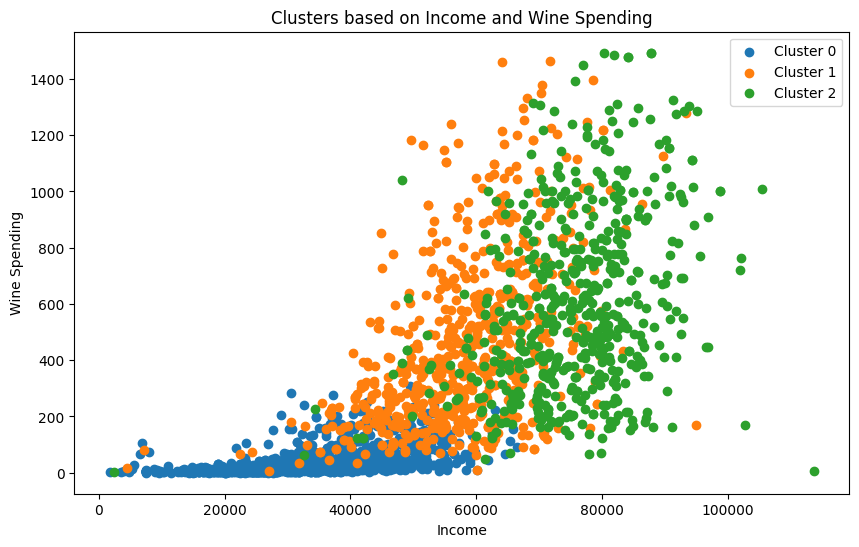

In [ ]:
# Apply K-Means clustering with the optimal number of clusters (e.g., 3 based on the Elbow Curve)
optimal_clusters = 3  # Change this based on the Elbow Curve
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(data_preprocessed)

# Add the cluster labels to the original DataFrame
df['Cluster'] = cluster_labels

# Evaluate the clustering with metrics
silhouette_avg = silhouette_score(data_preprocessed, cluster_labels)
print(f"Silhouette Score: {silhouette_avg:.2f}")

db_index = davies_bouldin_score(data_preprocessed, cluster_labels)
print(f"Davies-Bouldin Index: {db_index:.2f}")

# Visualize the clusters for two features (e.g., Income vs. MntWines)
plt.figure(figsize=(10, 6))
for cluster in range(optimal_clusters):
    cluster_data = df[df['Cluster'] == cluster]
    plt.scatter(cluster_data['Income'], cluster_data['MntWines'], label=f'Cluster {cluster}')
plt.title('Clusters based on Income and Wine Spending')
plt.xlabel('Income')
plt.ylabel('Wine Spending')
plt.legend()
plt.show()

## PCA + K Means Clustering

Silhouette Score with PCA: 0.51
Davies-Bouldin Index with PCA: 0.71


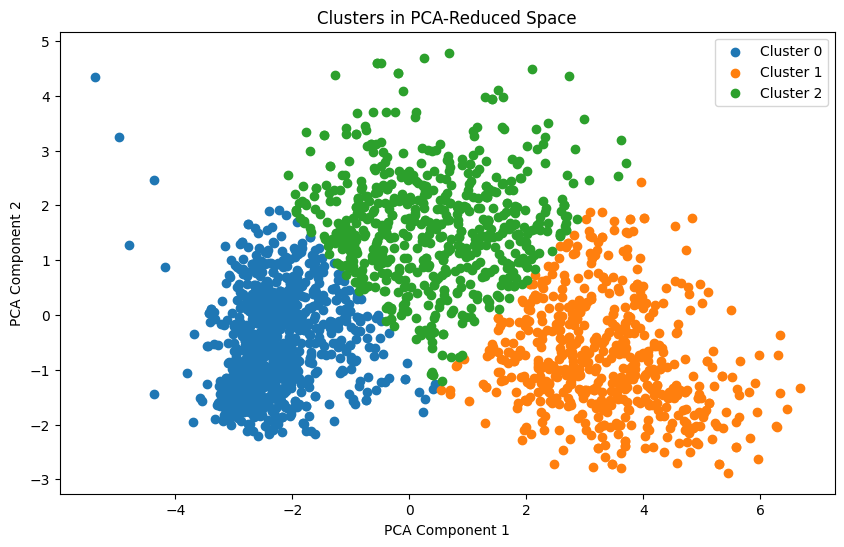

In [ ]:
# Remove rows with missing values in the Income column
df = df.dropna(subset=['Income'])

# Select features relevant for segmentation
features = [
    'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome',
    'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
    'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth'
]
df = df[features]

# Identify and remove outliers in the Income column
Q1 = df['Income'].quantile(0.25)
Q3 = df['Income'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['Income'] >= lower_bound) & (df['Income'] <= upper_bound)]

# Define numerical and categorical features for preprocessing
numerical_features = ['Year_Birth', 'Income', 'Kidhome', 'Teenhome',
                      'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
                      'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
                      'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
categorical_features = ['Education', 'Marital_Status']

# Apply StandardScaler to numerical features
numerical_transformer = StandardScaler()

# Apply OneHotEncoder to categorical features
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

# Combine the transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Transform the data using the preprocessing pipeline
data_preprocessed = preprocessor.fit_transform(df)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)  # Reduce to 2 dimensions for better visualization and clustering
pca_data = pca.fit_transform(data_preprocessed)

# Apply K-Means clustering with the optimal number of clusters (e.g., 3 based on the Elbow Curve)
optimal_clusters = 3  # Change this based on the Elbow Curve
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(pca_data)

# Add the cluster labels to the original DataFrame
df['Cluster'] = cluster_labels

# Evaluate the clustering with metrics
silhouette_avg = silhouette_score(pca_data, cluster_labels)
print(f"Silhouette Score with PCA: {silhouette_avg:.2f}")

db_index = davies_bouldin_score(pca_data, cluster_labels)
print(f"Davies-Bouldin Index with PCA: {db_index:.2f}")

# Visualize the clusters in PCA-reduced space
plt.figure(figsize=(10, 6))
for cluster in range(optimal_clusters):
    cluster_data = pca_data[df['Cluster'] == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}')
plt.title('Clusters in PCA-Reduced Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

## Cluster Analysis

In [ ]:
# Select only numeric columns for grouping
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Group by clusters and calculate mean for numeric columns only
cluster_summary = df.groupby('Cluster')[numeric_columns].mean()

# Print the summary for interpretation
print(cluster_summary)


          Year_Birth        Income   Kidhome  Teenhome    MntWines  MntFruits  \
Cluster                                                                         
0        1972.099391  33684.117647  0.806288  0.421907   38.040568   4.920892   
1        1968.381426  75158.766169  0.046434  0.190713  602.180763  68.951907   
2        1963.977383  57308.234249  0.247173  0.948304  444.665590  19.287561   

         MntMeatProducts  MntFishProducts  MntSweetProducts  MntGoldProds  \
Cluster                                                                     
0              22.494929         6.994929          5.015213     15.121704   
1             438.699834        99.346600         70.366501     77.728027   
2             126.610662        26.765751         20.210016     57.539580   

         NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  \
Cluster                                                            
0                 2.015213         2.066937             0.522312   
1   

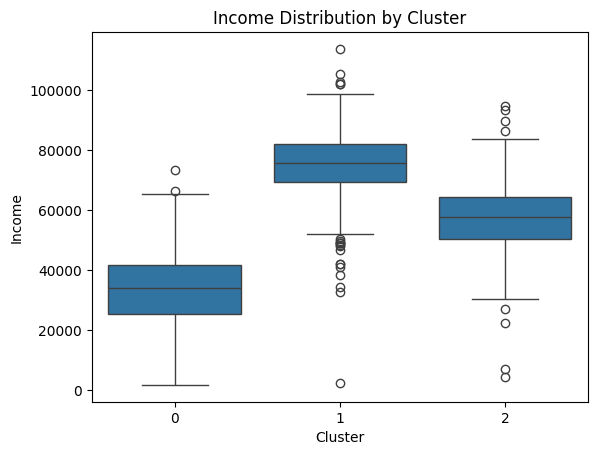

In [ ]:
# Visualize Income distribution by cluster
sns.boxplot(x='Cluster', y='Income', data=df)
plt.title('Income Distribution by Cluster')
plt.show()

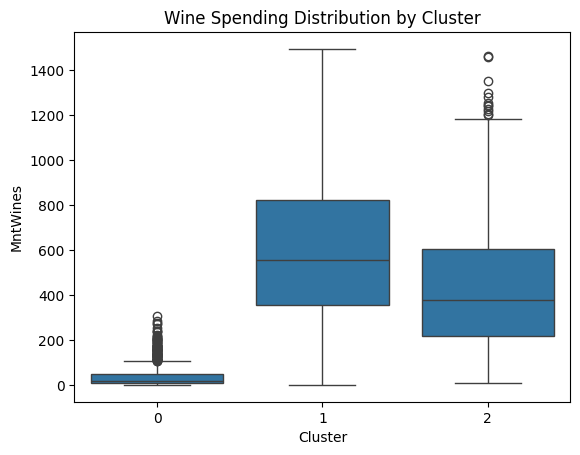

In [ ]:
# Visualize Wine Spending distribution by cluster
sns.boxplot(x='Cluster', y='MntWines', data=df)
plt.title('Wine Spending Distribution by Cluster')
plt.show()

## Cluster Interpretations

### Cluster 0: Budget-Conscious Customers
- **Income**: Average income is the lowest at 33,684.
- **Spending**: Minimal spending across all categories, including wines (38 on average).
  - Very low spending on meat, fish, sweets, and gold products.
- **Family Composition**: Highest number of children (Kidhome: 0.81) and teens (Teenhome: 0.42).
- **Engagement**:
  - Low engagement in online and catalog purchases (NumWebPurchases: 2.06, NumCatalogPurchases: 0.52).
  - Moderate store purchases (3.16) and frequent website visits (6.52).
- **Demographics**: Older age group (average birth year 1972).

#### Marketing Insights for Cluster 0:
1. Focus on affordable product bundles and discounted offers.
2. Use email campaigns with budget-conscious messaging.
3. Highlight loyalty programs to encourage repeat purchases.

### Cluster 1: Affluent High-Spenders
- **Income**: Highest average income at 75,158.
- **Spending**:
  - Significant spending on wines (602), meat (438), fish, sweets, and gold products.
  - They spend the most across all product categories.
- **Family Composition**: Few children (Kidhome: 0.05) and teens (Teenhome: 0.19).
- **Engagement**:
  - Highly engaged in online and catalog purchases (NumWebPurchases: 5.27, NumCatalogPurchases: 5.83).
  - High store purchases (8.51) but the least frequent website visits (2.91).
- **Demographics**: Older individuals (average birth year 1968).

#### Marketing Insights for Cluster 1:
1. Target with luxury and premium product offerings.
2. Provide exclusive VIP benefits, such as early access or premium memberships.
3. Leverage catalog and online channels for personalized product recommendations.

### Cluster 2: Mid-Level Spenders
- **Income**: Moderate average income at 57,308.
- **Spending**:
  - Moderate spending across categories, especially wines (444) and gold products (57).
  - Moderate but lower spending compared to Cluster 1 in meat, fish, sweets.
- **Family Composition**: Higher number of teens (Teenhome: 0.94) than other clusters, but fewer children (Kidhome: 0.24).
- **Engagement**:
  - Active in online purchases (NumWebPurchases: 6.19) and store purchases (7.43).
  - Moderate website visits (5.79) and catalog purchases (2.92).
- **Demographics**: Older individuals (average birth year 1963).

#### Marketing Insights for Cluster 2:
1. Highlight value-driven products that balance quality and affordability.
2. Offer family-oriented promotions or discounts for larger households.
3. Use a combination of online and in-store strategies to retain these customers.

### Recommendations for Marketing:
1. **Cluster-Specific Strategies**:
   - Cluster 0: Promote affordability, discounts, and savings.
   - Cluster 1: Focus on exclusivity, luxury items, and personalized services.
   - Cluster 2: Emphasize value and quality with family-friendly offerings.
2. **Channel Preferences**:
   - Cluster 1 relies heavily on catalogs and online purchases; focus on targeted recommendations.
   - Cluster 2 is more evenly distributed between online and in-store; use hybrid marketing strategies.
3. **Engagement Tactics**:
   - For Cluster 0: Frequent, cost-focused communication.
   - For Cluster 1: High-touch personalized services and luxury loyalty rewards.
   - For Cluster 2: Balance digital and in-store engagement.